In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import product
import statsmodels.api as sm
from PortfolioAnalysis import *

from DataPipeline import DataPipeline, MSE, R2, r2_metrics

file_path = '/Users/zequnli/LocalData/'

2024-05-15 16:06:02.162193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# OOS R-squared

In [2]:
# load data
dataset = DataPipeline(file_path)

In [19]:
train_mask = ((dataset.data['yyyymm']>196400)&(dataset.data['yyyymm'] < 197500))
train_N = train_mask.sum()
validation_mask = (dataset.data['yyyymm'] >= 197500) & (dataset.data['yyyymm'] < 198900)
validation_N = validation_mask.sum()
test_mask = (dataset.data['yyyymm'] > 198900)
test_N = test_mask.sum()
N = dataset.data.shape[0]

In [58]:
# initiate a result dataframe
# yyyymm and permno for merging purpose
# me and exret for calculating portfolio return
OOSresults = dataset.data[['yyyymm','permno','me','exret']][test_mask].copy()

In [59]:
# Initiate a comparison dataframe
comparison = {}

## Naive Model

In [60]:
OOSresults = OOSresults.assign(pred_naive = np.zeros(OOSresults.shape[0]))

In [61]:
# naive prediction
comparison['Naive'] = {}
comparison['Naive']['testing MSE'] = MSE(dataset.data[test_mask]['exret'], np.zeros(test_N))
comparison['Naive']['testing R2'] = R2(dataset.data[test_mask]['exret'], np.zeros(test_N))

## Fama-Macbeth Regression

In [64]:
params = {}
result_insample = []
for year,month in product(range(1963,2022),range(1,13)):
    if year == 1963 and month < 7:
        continue
    X,Y, _ = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X)
    lr = sm.OLS(Y,X).fit()
    params[year*100+month] = lr.params
    result_insample.extend(lr.predict(X))
params = pd.DataFrame(params).T
# time: 40s

In [65]:
result_oos = []
for year,month in product(range(1989,2022),range(1,13)):
    X,Y, month_result = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X)
    param = params.rolling(12).mean().shift().loc[year*100+month]
    result_oos.extend(X.dot(param))

OOSresults = OOSresults.assign(pred_fm = result_oos)
# time: 24s

In [67]:
comparison['FM'] = {}
comparison['FM']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm'])
comparison['FM']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm'])

## FM-5

In [69]:
params = {}
result_insample = []
for year,month in product(range(1963,2022),range(1,13)):
    if year == 1963 and month < 7:
        continue
    X,Y, _ = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X[['mvel1','bm','mom12m','operprof','agr']])
    lr = sm.OLS(Y,X).fit()
    params[year*100+month] = lr.params
    result_insample.extend(lr.predict(X))
params = pd.DataFrame(params).T

In [70]:
result_oos = []
for year,month in product(range(1989,2022),range(1,13)):
    X,Y, month_result = dataset.LoadOneMonthXY(year,month)
    X = X[['mvel1','bm','mom12m','operprof','agr']]
    if year < 1975:
        result_oos.extend(np.zeros(X.shape[0]))
        continue
    X = sm.add_constant(X)
    param = params.rolling(12).mean().shift().loc[year*100+month]
    result_oos.extend(X.dot(param))

OOSresults = OOSresults.assign(pred_fm5 = result_oos)

In [71]:
comparison['FM5'] = {}
comparison['FM5']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm5'])
comparison['FM5']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm5'])

## NN3

In [49]:
from tensorflow.keras.models import load_model

y_test = []
y_pred = []
for year in range(1989,2022):
    model = load_model(file_path+'NN3_model/NN3_'+str(year)+'.keras', custom_objects={'r2_metrics': r2_metrics})
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

2024-05-15 15:46:14.806500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2440/2440 [==============================] - 2s 749us/step


In [72]:
OOSresults = OOSresults.assign(pred_nn3 = np.array(y_pred).reshape(-1))

In [74]:
comparison['NN3'] = {}
comparison['NN3']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_nn3'])
comparison['NN3']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_nn3'])

## RF

In [76]:
from joblib import load
y_test = []
y_pred = []
for year in range(1989,2022):
    model = load(file_path+'RF_model/RF_'+str(year)+'.joblib')
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

In [78]:
OOSresults = OOSresults.assign(pred_rf = np.array(y_pred).reshape(-1))

In [81]:
comparison['RF'] = {}
comparison['RF']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf'])

## Summarize

In [83]:
# save OOS result
OOSresults.to_csv(file_path + 'OOSresults.csv')

In [84]:
pd.DataFrame(comparison)

,Naive,FM,FM5,NN3,RF
testing MSE,344.628409,348.144004,347.267597,342.955236,343.936011
testing R2,0.000000,-0.010201,-0.007658,0.004855,0.002009


# OOS portfolio

In [4]:
import statsmodels.api as sm
import scipy.stats as stats
def newey_west_t_stat(y, maxlag=None):
    x = np.ones_like(y)
    nobs = len(y)
    lags = int(np.ceil(12 * np.power(nobs / 100, 1/4))) # choose number of lags, this is just an example
    model = sm.OLS(y, x)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags':lags, 'use_correction':True})

    # Calculate the Newey-West t-statistic for the mean of y
    t = results.params[0] / results.bse[0]
    p_value = 2 * (1 - stats.t.cdf(np.abs(t), nobs - 1))


        # Return a pandas Series with named elements
    return pd.Series({
        'mean': np.mean(y),
        'bse': results.bse[0],
        't_stats': t,
        'p_value': p_value,
        'SR': np.sqrt(12)*np.mean(y)/np.std(y)
    })

## All Data

In [2]:
OOSresults = pd.read_csv(file_path + 'OOSresults.csv',index_col=0)
OOSresults['yyyymm'] = pd.to_datetime(OOSresults['yyyymm'], format='%Y%m')+ pd.offsets.MonthEnd(1)

In [16]:
OOSresults['fm_rank'] = OOSresults.groupby('yyyymm')['pred_fm'].transform(lambda x: x.rank(pct = True))
OOSresults['fm_portfolio'] = OOSresults.groupby('yyyymm')['fm_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm_EW_portfolio = OOSresults.groupby(['yyyymm','fm_portfolio'])['exret'].mean().reset_index()
fm_EW_portfolio = fm_EW_portfolio.pivot(index='yyyymm', columns='fm_portfolio', values='exret')
fm_EW_portfolio['HML'] = fm_EW_portfolio['Hi 10'] - fm_EW_portfolio['Lo 10'] 
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.34,0.30,0.59,0.64,0.76,0.87,1.02,1.23,1.45,2.21,2.55
bse,0.38,0.31,0.28,0.26,0.24,0.24,0.26,0.29,0.32,0.45,0.41
t_stats,-0.91,0.98,2.12,2.49,3.17,3.60,3.85,4.25,4.49,4.91,6.27
p_value,0.37,0.33,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.15,0.16,0.35,0.41,0.53,0.62,0.71,0.81,0.87,1.00,1.05


In [17]:
OOSresults['fm5_rank'] = OOSresults.groupby('yyyymm')['pred_fm5'].transform(lambda x: x.rank(pct = True))
OOSresults['fm5_portfolio'] = OOSresults.groupby('yyyymm')['fm5_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm5_EW_portfolio = OOSresults.groupby(['yyyymm','fm5_portfolio'])['exret'].mean().reset_index()
fm5_EW_portfolio = fm5_EW_portfolio.pivot(index='yyyymm', columns='fm5_portfolio', values='exret')
fm5_EW_portfolio['HML'] = fm5_EW_portfolio['Hi 10'] - fm5_EW_portfolio['Lo 10'] 
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm5_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.41,0.57,0.57,0.67,0.69,0.71,0.88,1.04,1.34,1.84,1.43
bse,0.36,0.33,0.28,0.26,0.25,0.24,0.25,0.25,0.31,0.41,0.28
t_stats,1.15,1.75,2.03,2.61,2.73,2.90,3.53,4.17,4.36,4.49,5.09
p_value,0.25,0.08,0.04,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.17,0.30,0.35,0.44,0.47,0.51,0.65,0.74,0.82,0.90,0.64


In [18]:
OOSresults['nn3_rank'] = OOSresults.groupby('yyyymm')['pred_nn3'].transform(lambda x: x.rank(pct = True))
OOSresults['nn3_portfolio'] = OOSresults.groupby('yyyymm')['nn3_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

nn3_EW_portfolio = OOSresults.groupby(['yyyymm','nn3_portfolio'])['exret'].mean().reset_index()
nn3_EW_portfolio = nn3_EW_portfolio.pivot(index='yyyymm', columns='nn3_portfolio', values='exret')
nn3_EW_portfolio['HML'] = nn3_EW_portfolio['Hi 10'] - nn3_EW_portfolio['Lo 10'] 
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

nn3_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.99,0.17,0.44,0.59,0.79,1.00,1.02,1.25,1.54,2.88,3.87
bse,0.47,0.33,0.29,0.24,0.23,0.22,0.23,0.25,0.30,0.50,0.49
t_stats,-2.09,0.52,1.50,2.42,3.44,4.49,4.46,5.02,5.19,5.71,7.92
p_value,0.04,0.60,0.13,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.41,0.09,0.29,0.46,0.64,0.79,0.78,0.88,0.98,1.13,2.69


In [19]:
OOSresults['rf_rank'] = OOSresults.groupby('yyyymm')['pred_rf'].transform(lambda x: x.rank(pct = True))
OOSresults['rf_portfolio'] = OOSresults.groupby('yyyymm')['rf_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

rf_EW_portfolio = OOSresults.groupby(['yyyymm','rf_portfolio'])['exret'].mean().reset_index()
rf_EW_portfolio = rf_EW_portfolio.pivot(index='yyyymm', columns='rf_portfolio', values='exret')
rf_EW_portfolio['HML'] = rf_EW_portfolio['Hi 10'] - rf_EW_portfolio['Lo 10'] 
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

rf_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.22,0.30,0.37,0.58,0.70,0.88,1.00,1.13,1.34,2.66,2.88
bse,0.41,0.31,0.29,0.26,0.25,0.24,0.25,0.26,0.27,0.48,0.43
t_stats,-0.54,0.98,1.25,2.21,2.75,3.60,3.98,4.41,4.92,5.54,6.77
p_value,0.59,0.33,0.21,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.10,0.17,0.22,0.39,0.50,0.64,0.73,0.81,0.88,1.17,2.02


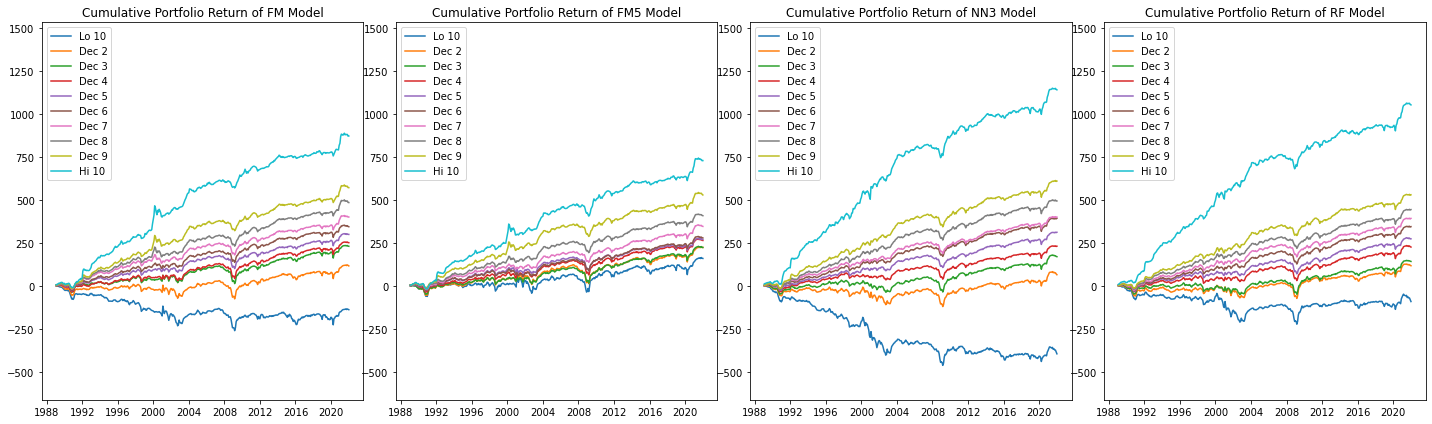

In [21]:
# Calculate the maximum and minimum cumulative sum across all portfolios and quantiles
max_cumsum = max(fm_EW_portfolio.cumsum().max().max(), fm5_EW_portfolio.cumsum().max().max(), nn3_EW_portfolio.cumsum().max().max(), rf_EW_portfolio.cumsum().max().max())
min_cumsum = min(fm_EW_portfolio.cumsum().min().min(), fm5_EW_portfolio.cumsum().min().min(), nn3_EW_portfolio.cumsum().min().min(), rf_EW_portfolio.cumsum().min().min())


fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot each portfolio's cumulative sum on its own subplot
axs[0].plot(fm_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[0].set_title('Cumulative Portfolio Return of FM Model')
axs[0].legend()

axs[1].plot(fm5_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[1].set_title('Cumulative Portfolio Return of FM5 Model')
axs[1].legend()


axs[2].plot(nn3_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].fillna(0).cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[2].set_title('Cumulative Portfolio Return of NN3 Model')
axs[2].legend()

axs[3].plot(rf_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[3].set_title('Cumulative Portfolio Return of RF Model')
axs[3].legend()

# Set the same y-axis limits for all subplots based on the max and min calculated
for ax in axs:
    ax.set_ylim(min_cumsum - 200, max_cumsum)


# Improve layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

## Exclude Small

In [37]:
OOSresults = pd.read_csv(file_path + 'OOSresults.csv',index_col=0)
OOSresults['yyyymm'] = pd.to_datetime(OOSresults['yyyymm'], format='%Y%m')+ pd.offsets.MonthEnd(1)
OOSresults = OOSresults[OOSresults['me']>50].copy()

In [38]:
OOSresults['fm_rank'] = OOSresults.groupby('yyyymm')['pred_fm'].transform(lambda x: x.rank(pct = True))
OOSresults['fm_portfolio'] = OOSresults.groupby('yyyymm')['fm_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm_EW_portfolio = OOSresults.groupby(['yyyymm','fm_portfolio'])['exret'].mean().reset_index()
fm_EW_portfolio = fm_EW_portfolio.pivot(index='yyyymm', columns='fm_portfolio', values='exret')
fm_EW_portfolio['HML'] = fm_EW_portfolio['Hi 10'] - fm_EW_portfolio['Lo 10'] 
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.91,1.07,1.16,1.15,1.14,1.23,1.31,1.48,1.73,2.49,1.58
bse,0.31,0.25,0.24,0.23,0.21,0.22,0.25,0.27,0.32,0.46,0.42
t_stats,2.96,4.24,4.78,5.01,5.46,5.55,5.32,5.42,5.36,5.39,3.76
p_value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.39,0.58,0.70,0.77,0.81,0.89,0.94,0.99,1.04,1.14,0.65


In [39]:
OOSresults['fm5_rank'] = OOSresults.groupby('yyyymm')['pred_fm5'].transform(lambda x: x.rank(pct = True))
OOSresults['fm5_portfolio'] = OOSresults.groupby('yyyymm')['fm5_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm5_EW_portfolio = OOSresults.groupby(['yyyymm','fm5_portfolio'])['exret'].mean().reset_index()
fm5_EW_portfolio = fm5_EW_portfolio.pivot(index='yyyymm', columns='fm5_portfolio', values='exret')
fm5_EW_portfolio['HML'] = fm5_EW_portfolio['Hi 10'] - fm5_EW_portfolio['Lo 10'] 
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm5_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,1.43,1.14,1.11,1.06,1.02,1.07,1.18,1.35,1.68,2.63,1.20
bse,0.30,0.27,0.24,0.23,0.23,0.22,0.22,0.24,0.30,0.48,0.41
t_stats,4.80,4.25,4.53,4.64,4.42,4.86,5.38,5.63,5.59,5.48,2.96
p_value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.61,0.62,0.70,0.71,0.72,0.79,0.89,0.98,1.07,1.24,0.53


In [40]:
OOSresults['nn3_rank'] = OOSresults.groupby('yyyymm')['pred_nn3'].transform(lambda x: x.rank(pct = True))
OOSresults['nn3_portfolio'] = OOSresults.groupby('yyyymm')['nn3_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

nn3_EW_portfolio = OOSresults.groupby(['yyyymm','nn3_portfolio'])['exret'].mean().reset_index()
nn3_EW_portfolio = nn3_EW_portfolio.pivot(index='yyyymm', columns='nn3_portfolio', values='exret')
nn3_EW_portfolio['HML'] = nn3_EW_portfolio['Hi 10'] - nn3_EW_portfolio['Lo 10'] 
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

nn3_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.55,1.02,1.03,0.97,1.01,1.29,1.29,1.46,1.76,3.30,2.75
bse,0.46,0.29,0.26,0.23,0.22,0.23,0.21,0.23,0.26,0.36,0.37
t_stats,1.21,3.45,4.04,4.29,4.65,5.67,6.11,6.45,6.76,9.14,7.39
p_value,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.21,0.52,0.68,0.75,0.83,0.98,0.99,1.06,1.18,1.75,1.97


In [41]:
OOSresults['rf_rank'] = OOSresults.groupby('yyyymm')['pred_rf'].transform(lambda x: x.rank(pct = True))
OOSresults['rf_portfolio'] = OOSresults.groupby('yyyymm')['rf_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

rf_EW_portfolio = OOSresults.groupby(['yyyymm','rf_portfolio'])['exret'].mean().reset_index()
rf_EW_portfolio = rf_EW_portfolio.pivot(index='yyyymm', columns='rf_portfolio', values='exret')
rf_EW_portfolio['HML'] = rf_EW_portfolio['Hi 10'] - rf_EW_portfolio['Lo 10'] 
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

rf_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,1.18,1.10,1.09,1.03,1.14,1.19,1.32,1.44,1.59,2.59,1.40
bse,0.42,0.29,0.26,0.24,0.23,0.23,0.23,0.26,0.24,0.35,0.36
t_stats,2.80,3.79,4.19,4.25,4.91,5.26,5.80,5.61,6.70,7.50,3.91
p_value,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.51,0.62,0.66,0.69,0.82,0.88,0.98,1.05,1.11,1.36,0.91


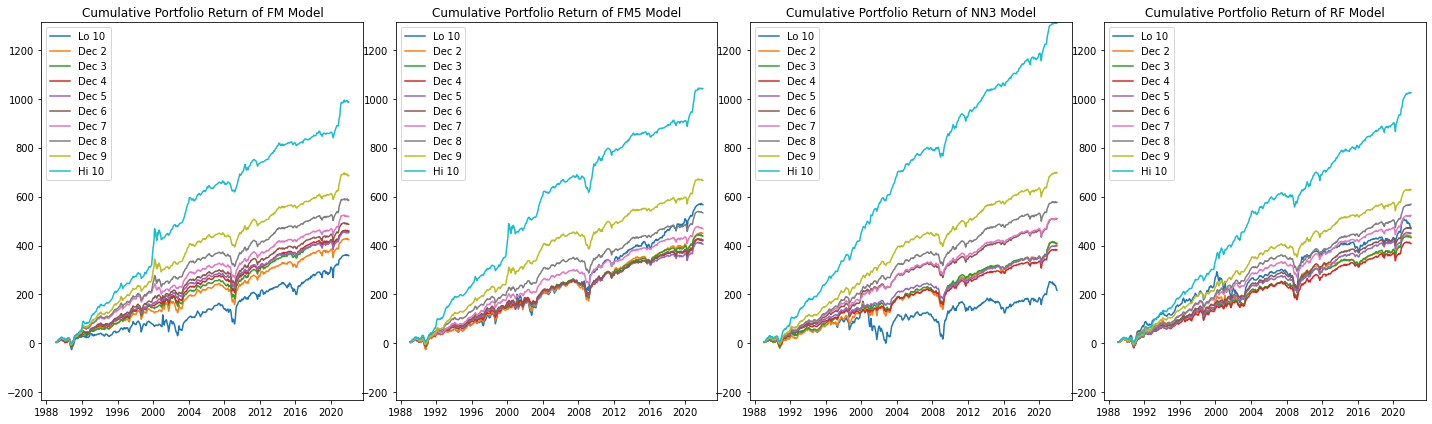

In [42]:
# Calculate the maximum and minimum cumulative sum across all portfolios and quantiles
max_cumsum = max(fm_EW_portfolio.cumsum().max().max(), fm5_EW_portfolio.cumsum().max().max(), nn3_EW_portfolio.cumsum().max().max(), rf_EW_portfolio.cumsum().max().max())
min_cumsum = min(fm_EW_portfolio.cumsum().min().min(), fm5_EW_portfolio.cumsum().min().min(), nn3_EW_portfolio.cumsum().min().min(), rf_EW_portfolio.cumsum().min().min())


fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot each portfolio's cumulative sum on its own subplot
axs[0].plot(fm_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[0].set_title('Cumulative Portfolio Return of FM Model')
axs[0].legend()

axs[1].plot(fm5_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[1].set_title('Cumulative Portfolio Return of FM5 Model')
axs[1].legend()


axs[2].plot(nn3_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].fillna(0).cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[2].set_title('Cumulative Portfolio Return of NN3 Model')
axs[2].legend()

axs[3].plot(rf_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[3].set_title('Cumulative Portfolio Return of RF Model')
axs[3].legend()

# Set the same y-axis limits for all subplots based on the max and min calculated
for ax in axs:
    ax.set_ylim(min_cumsum - 200, max_cumsum)


# Improve layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

## lag price > 5

In [50]:
OOSresults = pd.read_csv(file_path + 'OOSresults.csv',index_col=0)
crsp = pd.read_csv(file_path + 'crsp.csv')
OOSresults = OOSresults.merge(crsp[['permno','yyyymm','prc','shrcd','siccd']], on=['permno', 'yyyymm'], how='inner')
OOSresults['yyyymm'] = pd.to_datetime(OOSresults['yyyymm'], format='%Y%m')+ pd.offsets.MonthEnd(1)
OOSresults['lag_price'] = OOSresults.groupby('permno')['prc'].shift(1)
OOSresults = OOSresults[OOSresults['lag_price'] > 5]

In [51]:
OOSresults['fm_rank'] = OOSresults.groupby('yyyymm')['pred_fm'].transform(lambda x: x.rank(pct = True))
OOSresults['fm_portfolio'] = OOSresults.groupby('yyyymm')['fm_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm_EW_portfolio = OOSresults.groupby(['yyyymm','fm_portfolio'])['exret'].mean().reset_index()
fm_EW_portfolio = fm_EW_portfolio.pivot(index='yyyymm', columns='fm_portfolio', values='exret')
fm_EW_portfolio['HML'] = fm_EW_portfolio['Hi 10'] - fm_EW_portfolio['Lo 10'] 
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.16,0.39,0.57,0.65,0.69,0.81,0.85,0.92,1.12,1.46,1.62
bse,0.33,0.27,0.25,0.22,0.20,0.22,0.21,0.23,0.26,0.29,0.30
t_stats,-0.49,1.47,2.31,2.91,3.44,3.76,3.98,3.93,4.40,5.06,5.43
p_value,0.62,0.14,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.08,0.24,0.39,0.48,0.53,0.64,0.66,0.68,0.76,0.80,0.84


In [52]:
OOSresults['fm5_rank'] = OOSresults.groupby('yyyymm')['pred_fm5'].transform(lambda x: x.rank(pct = True))
OOSresults['fm5_portfolio'] = OOSresults.groupby('yyyymm')['fm5_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm5_EW_portfolio = OOSresults.groupby(['yyyymm','fm5_portfolio'])['exret'].mean().reset_index()
fm5_EW_portfolio = fm5_EW_portfolio.pivot(index='yyyymm', columns='fm5_portfolio', values='exret')
fm5_EW_portfolio['HML'] = fm5_EW_portfolio['Hi 10'] - fm5_EW_portfolio['Lo 10'] 
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm5_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.26,0.51,0.59,0.69,0.64,0.66,0.78,0.86,0.99,1.30,1.04
bse,0.33,0.28,0.24,0.22,0.23,0.20,0.20,0.21,0.23,0.27,0.23
t_stats,0.79,1.85,2.50,3.15,2.85,3.26,3.88,4.03,4.30,4.78,4.54
p_value,0.43,0.07,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.13,0.32,0.43,0.51,0.49,0.53,0.63,0.68,0.71,0.76,0.65


In [53]:
OOSresults['nn3_rank'] = OOSresults.groupby('yyyymm')['pred_nn3'].transform(lambda x: x.rank(pct = True))
OOSresults['nn3_portfolio'] = OOSresults.groupby('yyyymm')['nn3_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

nn3_EW_portfolio = OOSresults.groupby(['yyyymm','nn3_portfolio'])['exret'].mean().reset_index()
nn3_EW_portfolio = nn3_EW_portfolio.pivot(index='yyyymm', columns='nn3_portfolio', values='exret')
nn3_EW_portfolio['HML'] = nn3_EW_portfolio['Hi 10'] - nn3_EW_portfolio['Lo 10'] 
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

nn3_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.61,0.23,0.53,0.62,0.74,0.96,0.93,1.10,1.28,1.52,2.13
bse,0.40,0.28,0.23,0.21,0.21,0.21,0.20,0.21,0.24,0.28,0.34
t_stats,-1.52,0.83,2.24,2.88,3.56,4.48,4.67,5.26,5.34,5.53,6.28
p_value,0.13,0.41,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.27,0.14,0.41,0.52,0.64,0.77,0.75,0.86,0.91,1.00,1.65


In [54]:
OOSresults['rf_rank'] = OOSresults.groupby('yyyymm')['pred_rf'].transform(lambda x: x.rank(pct = True))
OOSresults['rf_portfolio'] = OOSresults.groupby('yyyymm')['rf_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

rf_EW_portfolio = OOSresults.groupby(['yyyymm','rf_portfolio'])['exret'].mean().reset_index()
rf_EW_portfolio = rf_EW_portfolio.pivot(index='yyyymm', columns='rf_portfolio', values='exret')
rf_EW_portfolio['HML'] = rf_EW_portfolio['Hi 10'] - rf_EW_portfolio['Lo 10'] 
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

rf_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.07,0.36,0.43,0.54,0.71,0.82,0.92,0.99,1.14,1.33,1.26
bse,0.35,0.25,0.24,0.23,0.24,0.22,0.22,0.23,0.21,0.27,0.28
t_stats,0.19,1.42,1.79,2.35,3.00,3.70,4.11,4.37,5.34,4.92,4.56
p_value,0.85,0.16,0.07,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.03,0.24,0.30,0.39,0.54,0.65,0.73,0.78,0.87,0.84,0.99


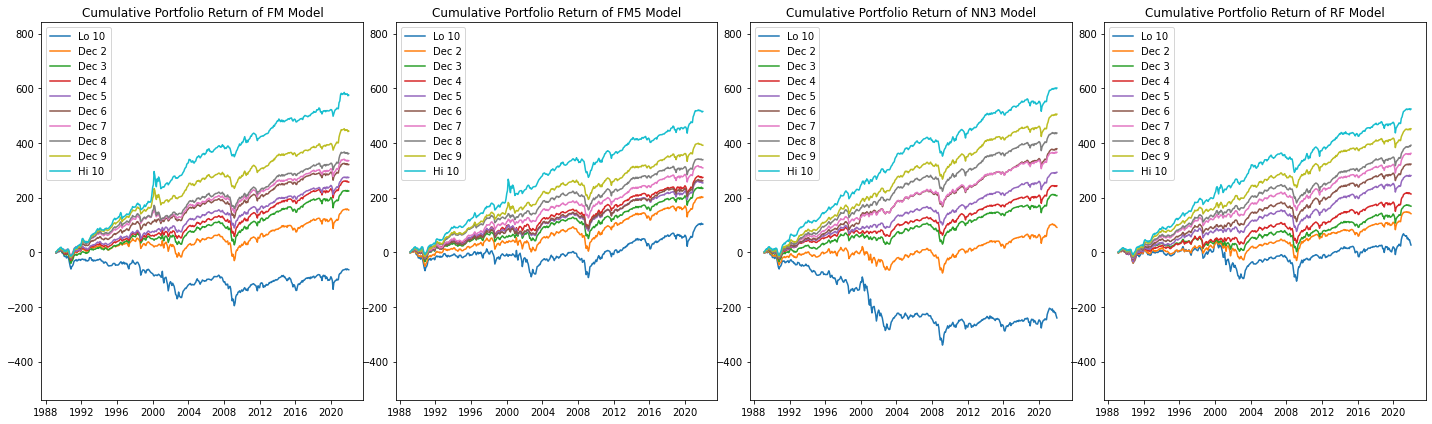

In [55]:
# Calculate the maximum and minimum cumulative sum across all portfolios and quantiles
max_cumsum = max(fm_EW_portfolio.cumsum().max().max(), fm5_EW_portfolio.cumsum().max().max(), nn3_EW_portfolio.cumsum().max().max(), rf_EW_portfolio.cumsum().max().max())
min_cumsum = min(fm_EW_portfolio.cumsum().min().min(), fm5_EW_portfolio.cumsum().min().min(), nn3_EW_portfolio.cumsum().min().min(), rf_EW_portfolio.cumsum().min().min())


fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot each portfolio's cumulative sum on its own subplot
axs[0].plot(fm_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[0].set_title('Cumulative Portfolio Return of FM Model')
axs[0].legend()

axs[1].plot(fm5_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[1].set_title('Cumulative Portfolio Return of FM5 Model')
axs[1].legend()


axs[2].plot(nn3_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].fillna(0).cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[2].set_title('Cumulative Portfolio Return of NN3 Model')
axs[2].legend()

axs[3].plot(rf_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[3].set_title('Cumulative Portfolio Return of RF Model')
axs[3].legend()

# Set the same y-axis limits for all subplots based on the max and min calculated
for ax in axs:
    ax.set_ylim(min_cumsum - 200, max_cumsum)


# Improve layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()